# <span style="color:#1A1E5A"> **서울과 부산에 존재하는 아파트의 실제 거래 가격 예측**
=> Regression 문제

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import os
import time
import datetime
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
import seaborn as sns
%matplotlib inline

- DataFrame 생성

In [2]:
df = pd.read_csv('train.csv')
park = pd.read_csv('park.csv')
dcc = pd.read_csv('day_care_center.csv')
test = pd.read_csv('test.csv')
interest = pd.read_csv('interest.csv')

# **01. Preprocessing**
#### Feature Engineering & Cleansing

> ### Train 데이터
- apartment_id / 아파트 아이디
- city / 도시
- dong / 동
- jibun / 지번
- apt / 아파트단지 이름
- addr_kr / 주소
- exclusive_use_area / 전용면적
- year_of_completion / 설립일자
- transaction_year_month / 거래년월
- transaction_date / 거래날짜
- floor / 층
- transaction_real_price / 실거래가

In [3]:
# Preprocessing & Feature Engineering
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

 <span style="background-color:#DCFFE4"> **동 & 구**

In [4]:
### dong: 동 이름에서 숫자 빼기 & ~읍~리 인 경우, "~리"만 살리기
df['dong'] = df['dong'].apply(lambda x: re.search(r'(\D+)', x).group() if re.search(r'(\D+)', x) else x)
df['dong'] = df['dong'].apply(lambda x: re.search(r'(.+읍)', x).group() if re.search(r'(.+읍)', x) else x)

test['dong'] = test['dong'].apply(lambda x: re.search(r'(\D+)', x).group() if re.search(r'(\D+)', x) else x)
test['dong'] = test['dong'].apply(lambda x: re.search(r'(.+읍)', x).group() if re.search(r'(.+읍)', x) else x)

In [5]:
# 동을 해당하는 구에 mapping
dong_to_gu_mapping = {
    '서대신동': '서구', '대연동': '남구', '논현동': '강남구', '하계동': '노원구', '방배동': '서초구',
    '월계동': '노원구', '범천동': '부산진구', '광장동': '광진구', '안암동': '성북구', '방화동': '강서구',
    '장림동': '사하구', '모라동': '사상구', '대림동': '영등포구', '남천동': '수영구', '평창동': '종로구',
    '당감동': '부산진구', '신당동': '중구', '한강로': '용산구', '양정동': '부산진구', '하단동': '사하구',
    '성내동': '강동구', '개포동': '강남구', '이태원동': '용산구', '서교동': '마포구', '온천동': '동래구',
    '상계동': '노원구', '개금동': '부산진구', '청담동': '강남구', '신정동': '마포구', '노량진동': '동작구',
    '연산동': '연제구', '다대동': '사하구', '용호동': '남구', '냉천동': '서대문구', '대치동': '강남구',
    '중계동': '노원구', '풍납동': '송파구', '동삼동': '영도구', '좌동': '해운대구', '문배동': '용산구',
    '역삼동': '강남구', '명지동': '강서구', '신수동': '마포구', '자양동': '광진구', '묵동': '양천구',
    '장위동': '성북구', '둔촌동': '강동구', '광안동': '수영구', '우동': '해운대구', '부전동': '부산진구',
    '하월곡동': '성북구', '길음동': '성북구', '봉천동': '관악구', '괴정동': '사하구', '구로동': '구로구',
    '반송동': '해운대구', '부암동': '종로구', '명장동': '동래구', '기장읍': '기장군', '학장동': '사상구',
    '화명동': '북구', '금곡동': '북구', '휘경동': '동대문구', '가락동': '송파구', '구포동': '북구',
    '공릉동': '노원구', '신도림동': '구로구', '익선동': '종로구', '잠실동': '송파구', '상도동': '동작구',
    '초량동': '동구', '망미동': '수영구', '주례동': '사상구', '갈현동': '은평구', '도곡동': '강남구',
    '서빙고동': '용산구', '양평동': '영등포구', '대방동': '동작구', '금호동': '성동구', '마곡동': '강서구',
    '성수동': '성동구', '쌍문동': '도봉구', '등촌동': '강서구', '신대방동': '동작구', '압구정동': '강남구',
    '부곡동': '금정구', '번동': '강북구', '남가좌동': '서대문구', '신림동': '관악구', '내발산동': '강서구',
    '답십리동': '동대문구', '중동': '동대문구', '거여동': '송파구', '통인동': '종로구', '문현동': '남구',
    '연지동': '부산진구', '가양동': '강서구', '지사동': '강서구', '구산동': '은평구', '성산동': '마포구',
    '돈암동': '성북구', '본동': '동작구', '우면동': '서초구', '신월동': '양천구', '상월곡동': '성북구',
    '장지동': '송파구', '도화동': '마포구', '화곡동': '강서구', '구의동': '광진구', '창동': '도봉구',
    '삼성동': '강남구', '신내동': '중랑구', '면목동': '중랑구', '동소문동': '성북구', '당산동': '영등포구',
    '엄궁동': '사상구', '방학동': '도봉구', '잠원동': '서초구', '명륜동': '종로구', '반여동': '해운대구',
    '미아동': '강북구', '가야동': '부산진구', '복천동': '동래구', '명일동': '강동구', '장안동': '동대문구',
    '황학동': '중구', '신호동': '강서구', '서초동': '서초구', '신천동': '송파구', '응봉동': '성동구',
    '천호동': '강동구', '정관읍': '기장군', '강일동': '강동구', '재송동': '해운대구', '불광동': '은평구',
    '신원동': '서초구', '원효로': '용산구', '보수동': '중구', '개봉동': '구로구', '신사동': '은평구',
    '행당동': '성동구', '중화동': '중랑구', '전포동': '부산진구', '거제동': '연제구', '도봉동': '도봉구',
    '고덕동': '강동구', '만덕동': '북구', '망원동': '마포구', '사직동': '종로구', '목동': '양천구',
    '상일동': '강동구', '일광면 삼성리': '기장군', '길동': '강동구', '안락동': '동래구', '수유동': '강북구',
    '하왕십리동': '성동구', '오금동': '송파구', '상봉동': '중랑구', '부민동': '서구', '사당동': '동작구',
    '청량리동': '동대문구', '이촌동': '용산구', '고척동': '구로구', '삼선동': '성북구', '용두동': '동대문구',
    '신평동': '사하구', '구서동': '금정구', '오류동': '구로구', '후암동': '용산구', '공덕동': '마포구',
    '문래동': '영등포구', '암사동': '강동구', '역촌동': '은평구', '당주동': '종로구', '당리동': '사하구',
    '장전동': '금정구', '정릉동': '성북구', '덕천동': '북구', '응암동': '은평구', '시흥동': '금천구',
    '신길동': '영등포구', '영선동': '영도구', '염창동': '강서구', '마장동': '성동구', '반포동': '서초구',
    '괘법동': '사상구', '도림동': '영등포구', '방이동': '송파구', '석관동': '성북구', '이문동': '동대문구',
    '낙민동': '동래구', '청룡동': '금정구', '전농동': '동대문구', '창전동': '마포구', '영주동': '중구',
    '일광면 이천리': '기장군', '신공덕동': '마포구', '금사동': '금정구', '일원동': '강남구', '홍익동': '성동구',
    '현저동': '서대문구', '옥수동': '성동구', '남산동': '중구', '망우동': '중랑구', '독산동': '금천구',
    '상왕십리동': '성동구', '봉래동': '영도구', '인현동': '중구', '종암동': '성북구', '감천동': '사하구',
    '감만동': '남구', '여의도동': '영등포구', '문정동': '송파구', '흑석동': '동작구', '수색동': '은평구',
    '수서동': '강남구', '한남동': '용산구', '민락동': '수영구', '진관동': '은평구', '홍은동': '서대문구',
    '가산동': '금천구', '용당동': '남구', '중곡동': '광진구', '온수동': '구로구', '서동': '금정구',
    '남현동': '관악구', '회기동': '동대문구', '홍제동' : '서대문구',
    '명륜동': '동래구', '상일동': '강동구', '길동': '강동구', '안락동': '동래구', '하왕십리동': '성동구',
    '오금동': '동대문구', '사당동': '동작구', '청량리동': '동대문구', '이촌동': '용산구', '고척동': '구로구',
    '용두동': '강동구', '신평동': '사하구', '구서동': '금정구', '오류동': '구로구', '후암동': '용산구',
    '암사동': '강동구', '역촌동': '은평구', '당리동': '사하구', '장전동': '금정구', '덕천동': '북구',
    '응암동': '은평구', '시흥동': '금천구', '염창동': '강서구', '마장동': '성동구', '반포동': '서초구',
    '괘법동': '사상구', '도림동': '영등포구', '방이동': '송파구', '이문동': '동대문구', '낙민동': '동래구',
    '청룡동': '금정구', '전농동': '동대문구', '영주동': '중구', '금사동': '금정구', '일원동': '강남구',
    '홍익동': '성동구', '현저동': '서대문구', '옥수동': '성동구', '남산동': '금정구', '독산동': '금천구',
    '감천동': '사하구', '감만동': '남구', '문정동': '송파구', '흑석동': '동작구', '수색동': '은평구',
    '수서동': '강남구', '한남동': '용산구', '민락동': '수영구', '진관동': '은평구', '홍은동': '서대문구',
    '가산동': '금천구', '용당동': '남구', '온수동': '구로구', '서동': '금정구', '남현동': '관악구',
    '회기동': '동대문구', '홍제동': '서대문구', '우암동': '남구', '양재동': '서초구', '좌천동': '동구',
    '범일동': '동구', '내곡동': '서초구', '덕포동': '사상구', '구평동': '사하구', '송파동': '송파구',
    '마천동': '송파구', '북가좌동': '서대문구', '무악동': '종로구', '영등포동': '영등포구', '제기동': '동대문구',
    '녹번동': '은평구', '순화동': '중구', '용답동': '성동구', '수안동': '동래구', '대조동': '은평구',
    '대현동': '서대문구', '도원동': '용산구', '세곡동': '강남구', '석촌동': '송파구', '궁동': '구로구',
    '수영동': '수영구', '동작동': '동작구', '연희동': '서대문구', '송정동': '부산진구', '효창동': '용산구',
    '암남동': '서구', '우이동': '강북구', '증산동': '은평구', '화양동': '광진구', '범전동': '부산진구',
    '천왕동': '구로구', '영천동': '서대문구', '군자동': '광진구', '자곡동': '강남구', '북아현동': '서대문구',
    '사근동': '성동구', '신설동': '동대문구', '항동': '구로구', '회동동': '금정구', '공항동': '강서구',
    '합동': '서대문구', '신계동': '용산구', '남부민동': '서구', '정동': '중구', '삼전동': '송파구',
    '창천동': '서대문구', '율현동': '강남구', '칠산동': '동래구', '녹산동': '강서구', '동자동': '용산구',
    '능동': '광진구', '신창동': '용산구', 
    '남항동': '영도구', '창신동': '종로구', '상암동': '마포구', '청학동': '영도구', '수정동': '동구',
    '대평동': '영도구', '회현동': '중구', '토성동': '서구', '하중동': '마포구', '천연동': '서대문구',
    '상수동': '마포구', '숭인동': '종로구', '노고산동': '마포구', '흥인동': '중구', '신영동': '종로구',
    '대흥동': '마포구', '신선동': '영도구', '초읍': '부산진구', '충정로': '서대문구', '보광동': '용산구',
    '염리동': '마포구', '연남동': '마포구', '보문동': '성북구', '삼락동': '사상구', '충무동': '서구',
    '대창동': '중구', '철마면 고촌리': '기장군', '대청동': '중구', '중림동': '중구', '산천동': '용산구',
    '만리동': '중구', '현석동': '마포구', '합정동': '마포구', '아현동': '마포구', '동대신동': '서구',
    '용강동': '마포구', '상도': '동작구', '용문동': '용산구', '내수동': '종로구', '용산동': '용산구',
    '동광동': '중구', '동선동': '성북구', '토정동': '마포구', '아미동': '서구', '충무로': '중구',
    '동교동': '마포구', '인의동': '종로구', '마포동': '마포구', '을지로': '중구', '명륜': '종로구',
    '부평동': '중구', '장안읍': '기장군', '충신동': '종로구', '수송동': '종로구', '감전동': '사상구',
    '도선동': '성동구', '교북동': '종로구', '신교동': '종로구', '미근동': '서대문구', '부용동': '서구',
    '동숭동': '종로구', '대교동': '영도구', '필동': '중구', '청암동': '용산구', '청파동': '용산구',
    '갈월동': '용산구', '남대문로': '중구', '묵정동': '중구', '연건동': '종로구', '구수동': '마포구',
    '가리봉동': '구로구', '장충동': '중구', '필운동': '종로구', '성북동': '성북구', '행촌동': '종로구',
    '청운동': '종로구', '견지동': '종로구', '동빙고동': '용산구', '주성동': '용산구', '효제동': '종로구',
    '대저': '강서구', '신문로': '종로구',
    '낙원동': '종로구', '이화동': '종로구', '산림동': '중구', '중앙동': '관악구', '남창동': '중구',
    '예장동': '중구', '오장동': '중구', '구기동': '종로구', '누상동': '종로구', '혜화동': '종로구',
    '초장동': '서구', '교남동': '종로구', '옥인동' : '종로구' }

In [6]:
### gu 컬럼 생성
df['gu'] = df['dong'].map(dong_to_gu_mapping)
test['gu'] = test['dong'].map(dong_to_gu_mapping)

In [7]:
# "city는 다른데, dong이 같은 경우" 추출
grouped = df.groupby('dong')['city'].nunique()
result = grouped[grouped > 1]
result

dong
남산동    2
부암동    2
사직동    2
송정동    2
신창동    2
중동     2
Name: city, dtype: int64

In [8]:
## "city는 다른데, dong이 같은 경우만" gu 컬럼값 수정
# 남산동
df[(df['dong'] == '남산동') & (df['city'] == '서울특별시')]['gu'] = '중구'
df[(df['dong'] == '남산동') & (df['city'] == '부산광역시')]['gu'] = '금정구'
test[(test['dong'] == '남산동') & (test['city'] == '서울특별시')]['gu'] = '중구'
test[(test['dong'] == '남산동') & (test['city'] == '부산광역시')]['gu'] = '금정구'

# 부암동
df[(df['dong'] == '부암동') & (df['city'] == '서울특별시')]['gu'] = '종로구'
df[(df['dong'] == '부암동') & (df['city'] == '부산광역시')]['gu'] = '부산진구'
test[(test['dong'] == '부암동') & (test['city'] == '서울특별시')]['gu'] = '종로구'
test[(test['dong'] == '부암동') & (test['city'] == '부산광역시')]['gu'] = '부산진구'

# 사직동
df[(df['dong'] == '사직동') & (df['city'] == '서울특별시')]['gu'] = '종로구'
df[(df['dong'] == '사직동') & (df['city'] == '부산광역시')]['gu'] = '동래구'
test[(test['dong'] == '사직동') & (test['city'] == '서울특별시')]['gu'] = '종로구'
test[(test['dong'] == '사직동') & (test['city'] == '부산광역시')]['gu'] = '동래구'

# 송정동
df[(df['dong'] == '송정동') & (df['city'] == '서울특별시')]['gu'] = '성동구'
df[(df['dong'] == '송정동') & (df['city'] == '부산광역시')]['gu'] = '해운대구'
test[(test['dong'] == '송정동') & (test['city'] == '서울특별시')]['gu'] = '성동구'
test[(test['dong'] == '송정동') & (test['city'] == '부산광역시')]['gu'] = '해운대구'

# 신창동
df[(df['dong'] == '신창동') & (df['city'] == '서울특별시')]['gu'] = '용산구'
df[(df['dong'] == '신창동') & (df['city'] == '부산광역시')]['gu'] = '중구'
test[(test['dong'] == '신창동') & (test['city'] == '서울특별시')]['gu'] = '용산구'
test[(test['dong'] == '신창동') & (test['city'] == '부산광역시')]['gu'] = '중구'

# 중동
df[(df['dong'] == '중동') & (df['city'] == '서울특별시')]['gu'] = '마포구'
df[(df['dong'] == '중동') & (df['city'] == '부산광역시')]['gu'] = '해운대구'
test[(test['dong'] == '중동') & (test['city'] == '서울특별시')]['gu'] = '마포구'
test[(test['dong'] == '중동') & (test['city'] == '부산광역시')]['gu'] = '해운대구'

 <span style="background-color:#DCFFE4"> **날짜**

In [9]:
### 연, 월 컬럼 생성
df['transaction_year_month'] = pd.to_datetime(df['transaction_year_month'], format = '%Y%m')
df['year'] = df['transaction_year_month'].dt.year
df['month'] = df['transaction_year_month'].dt.month

test['transaction_year_month'] = pd.to_datetime(test['transaction_year_month'], format = '%Y%m')
test['year'] = test['transaction_year_month'].dt.year
test['month'] = test['transaction_year_month'].dt.month

 <span style="background-color:#DCFFE4"> **아파트**

In [10]:
df['apartment'] = df['apt']
test['apartment'] = test['apt']

In [11]:
### top 10 시공사 아파트 여부를 나타내는 컬럼 생성
df['top10'] = 0
test['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']
df['apt'] = df['apt'].fillna('others')

# top 10 시공사면 1, 아니면 0
for i, brand in enumerate(top10):
    df.loc[df['apt'].str.contains(brand), 'top10'] = 1
    test.loc[test['apt'].str.contains(brand), 'top10'] = 1

In [12]:
### 동일 아파트 수 (apt_counts) 열 생성
df['apt_counts'] = 0
df.groupby(['apt'])['apt_counts'].count()
train_df = pd.merge(df, df.groupby(['apt'])['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test['apt_counts'] = 0
test.groupby(['apt'])['apt_counts'].count()
test = pd.merge(test, test.groupby(['apt'])['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

In [13]:
### 'top10 시공사'와 '데이터에 많이 있는 아파트 대표 25개'에 해당하는 아파트 여부 컬럼 생성
df['transformed'] = False
test['transformed'] = False


# 데이터에 많이 있는 아파트 대표 25개 리스트
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
# top 10 시공사 키워드와 25개 리스트를 통합
apt_names_list = top10 + apt_names


# 'apt_names_list'의 키워드에 아파트명이 포함되면 해당 키워드로 아파트명을 통일
# 그리고 `transformed` 컬럼값을 True로 변경
for a in tqdm(apt_names_list):
    df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test.loc[test['apt'].str.contains(a), 'apt'] = a
    df.loc[train_df['apt'].str.contains(a), 'transformed'] = True
    test.loc[test['apt'].str.contains(a), 'transformed'] = True

# 아파트 이름이 변경되지 않았을 경우(`transformed=False` 일 경우) 아파트명을 'others'로 변경
for a in tqdm(apt_names):
    df.loc[~df['transformed'], 'apt'] = 'others'
    test.loc[~test['transformed'] , 'apt'] = 'others'

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 51.53it/s]


In [14]:
df.drop(columns = 'apt_counts', inplace=True)
test.drop(columns = 'apt_counts', inplace=True)

In [15]:
### "아파트 연차 컬럼" 생성 - 현재 연도에서 아파트 건축 연도를 빼서
df['apartment_age'] = df['year'] - df['year_of_completion']
test['apartment_age'] = test['year'] - test['year_of_completion']

# 면적 당 가격 계산
#df['price_per_sqm'] = df['transaction_real_price'] / df['exclusive_use_area']
# 층별 가격 계산
#df['price_floor'] = df['transaction_real_price'] / df['floor']

#거래 계절 열 생성
df['season'] = df['month'].apply(lambda x: 'spring' if 3 <= x <= 5 else ('summer' if 6 <= x <= 8 else ('fall' if 9 <= x <= 11 else 'winter')))
test['season'] = test['month'].apply(lambda x: 'spring' if 3 <= x <= 5 else ('summer' if 6 <= x <= 8 else ('fall' if 9 <= x <= 11 else 'winter')))
# 아파트 당 이전 거래 여부 피처 생성
df['previous_transaction'] = df.duplicated(subset=['apartment_id'], keep='first')
df['previous_transaction'] = df['previous_transaction'].apply(lambda x:  1 if x else 0)
test['previous_transaction'] = test.duplicated(subset=['apartment_id'], keep='first')
test['previous_transaction'] = test['previous_transaction'].apply(lambda x:  1 if x else 0)

<Axes: xlabel='year_of_completion', ylabel='transaction_real_price'>

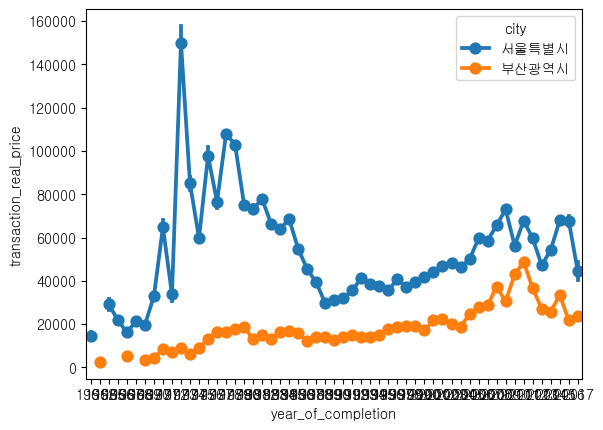

In [16]:
sns.pointplot(x='year_of_completion', y='transaction_real_price', hue = 'city', data = df)

 <span style="background-color:#DCFFE4">  **층** 

In [17]:
# 각 아파트 층 들을 범주화
df['floor_avg'] = 0
df.loc[df['floor'].between(0,10),'floor_avg'] = 1
df.loc[df['floor'].between(10,20),'floor_avg'] = 2
df.loc[df['floor'].between(20,30),'floor_avg'] = 3
df.loc[df['floor'].between(30,40),'floor_avg'] = 4
df.loc[df['floor'].between(40,50),'floor_avg'] = 5
df.loc[df['floor'].between(50,60),'floor_avg'] = 6
df.loc[df['floor'].between(60,70),'floor_avg'] = 7
df.loc[df['floor'].between(70,80),'floor_avg'] = 8

test['floor_avg'] = 0
test.loc[test['floor'].between(0,10),'floor_avg'] = 1
test.loc[test['floor'].between(10,20),'floor_avg'] = 2
test.loc[test['floor'].between(20,30),'floor_avg'] = 3
test.loc[test['floor'].between(30,40),'floor_avg'] = 4
test.loc[test['floor'].between(40,50),'floor_avg'] = 5
test.loc[test['floor'].between(50,60),'floor_avg'] = 6
test.loc[test['floor'].between(60,70),'floor_avg'] = 7
test.loc[test['floor'].between(70,80),'floor_avg'] = 8

In [18]:
# 거래 횟수가 많은 아파트는 따로 검색해보니 주상복합 아파트가 많음(아파트 거래 횟수가 낮은 층에 많았음)
# 즉, 아파트 밑에 있는 상가들이 많이 이전을 했다는 의미로 파악할 수 있음
# 밑에 있는 아파트들을 실제로 인터넷에 치면 주상복합임을 확인할 수 있음
# 따라서 표준편차의 2배 이상을 주상복합이라고 칭하기로 함

transaction = df.groupby(['apartment_id'])['transaction_year_month'].count().reset_index(name = 'number')
transaction['주상복합'] = 0
transaction.loc[list(transaction[transaction['number'] >= (transaction['number'].median()+transaction['number'].std()*2)].index),'주상복합'] = 1
transaction1 = test.groupby(['apartment_id'])['transaction_year_month'].count().reset_index(name = 'number')
transaction1['주상복합'] = 0
transaction1.loc[list(transaction1[transaction1['number'] >= (transaction['number'].median()+transaction['number'].std()*2)].index),'주상복합'] = 1

In [19]:
df = df.merge(transaction, how ='left', on = 'apartment_id')
test = test.merge(transaction1, how='left', on = 'apartment_id')

> ### day_care_center 데이터

- city / 도시 이름
- gu / 구
- day_care_name / 어린이집 이름
- day_care_type / 어린이집 종류
- day_care_baby_num / 정원수
- teacher_num / 보육교직원수
- nursing_room_num / 보육실수
- playground_num / 놀이터수
- CCTV_num / CCTV 설치수
- is_commuting_vehicle / 통학차량 운영여부
- reference_date / 데이터 기준일자(해당 데이터가 기록된 일자)

운동장, CCTV, 의무실 컬럼 결측치가 많아 사용 불가

공원 data에는 '동대문구'가 있지만 보육원 data에는 '동대문구'가 없다

 <span style="background-color:#DCFFE4">  **데이터 기록 일자** 

In [20]:
dcc['reference_date'] = pd.to_datetime(dcc['reference_date'])
dcc['year'] = dcc['reference_date'].dt.year
dcc['month'] = dcc['reference_date'].dt.month
dcc['day'] = dcc['reference_date'].dt.day

 <span style="background-color:#DCFFE4">  **통학차량 운영여부** 

In [21]:
dcc['is_commuting_vehicle'] = dcc['is_commuting_vehicle'].map({'N' : 0, 'n' : 0,'Y' : 1, 'y' : 1})

In [22]:
### gu 별 차량 여부 비율 컬럼 생성
vehicle = dcc.groupby(['gu'])['is_commuting_vehicle'].mean().reset_index(name = 'vehicle_pop')

## 결측치 처리(주변 구 별 평균을 통해 처리)
# 주변 구
# 강남 = 서초 + 송파
# 강동 = 송파 + 광진
# 강북 = 도봉 + 성북
# 동작 = 영등포 + 서초 + 관악
value = []
value.append((vehicle[vehicle['gu'] == '송파구']['vehicle_pop'].values + vehicle[vehicle['gu'] == '서초구']['vehicle_pop'].values)/2)
value.append((vehicle[vehicle['gu'] == '송파구']['vehicle_pop'].values + vehicle[vehicle['gu'] == '광진구']['vehicle_pop'].values)/2)
value.append((vehicle[vehicle['gu'] == '도봉구']['vehicle_pop'].values + vehicle[vehicle['gu'] == '노원구']['vehicle_pop'].values)/2)
value.append((vehicle[vehicle['gu'] == '영등포구']['vehicle_pop'].values + vehicle[vehicle['gu'] == '관악구']['vehicle_pop'].values)/2)
for idx,val in enumerate(vehicle['gu']):
    for i,j in enumerate(['강남구', '강동구', '강북구', '동작구']):
        if val == j:
            vehicle['vehicle_pop'][idx] = value[i]


# park 데이터 프레임과 병합
park = park.merge(vehicle, how = 'left', on = 'gu')
## 결측치 => 주변 구 별 평균으로 대체
park['vehicle_pop'].fillna((np.mean(park[park['gu'] == '중구']['vehicle_pop']) + np.mean(park[park['gu'] == '성동구']['vehicle_pop']))/2, inplace=True)

# train data에 결합
pop = park.groupby(['gu'])['vehicle_pop'].sum().to_dict()
df['vehicle_pop'] = df['gu'].map(pop)
## 결측치 => 주변 구 별 평균으로 대체
value = []
value.append((np.mean(df[df['gu'] == '용산구']['vehicle_pop']) + np.mean(df[df['gu'] == '서대문구']['vehicle_pop']))/2)
value.append((np.mean(df[df['gu'] == '강북구']['vehicle_pop']) + np.mean(df[df['gu'] == '동대문구']['vehicle_pop']))/2)
value.append((np.mean(df[df['gu'] == '금정구']['vehicle_pop']) + np.mean(df[df['gu'] == '해운대구']['vehicle_pop']))/2)
for idx,val in enumerate(df['gu']):
    for i,j in enumerate(['마포구','성북구','기장군']):
        if val == j:
            df['vehicle_pop'][idx] = value[i]

test['vehicle_pop'] = test['gu'].map(pop)
for idx,val in enumerate(test['gu']):
    for i,j in enumerate(['마포구','성북구','기장군']):
        if val == j:
            test['vehicle_pop'][idx] = value[i]

<Axes: xlabel='gu'>

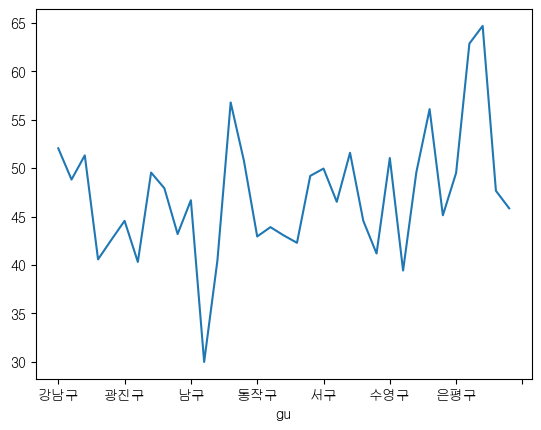

In [23]:
dcc.groupby(['gu'])['day_care_baby_num'].mean().plot()

 <span style="background-color:#DCFFE4">  **어린이집 종류** 

In [24]:
### 유형 별 아이 비율 컬럼 생성
gd = dcc.groupby(['day_care_type'])['day_care_baby_num'].mean().reset_index(name = 'baby')
result = dcc.merge(gd, how='left', on='day_care_type')
#각각의 비율을 구를 기준으로 합치기
result = result.groupby(['gu'])['baby'].sum().reset_index()
df = df.merge(result, how='left', on ='gu')
test = test.merge(result, how='left', on ='gu')

In [25]:
## 결측치 => 주변 구 별 평균으로 대체
value = []
value.append((np.mean(df[df['gu'] == '은평구']['baby']) + np.mean(df[df['gu'] == '서대문구']['baby']))/2)
value.append((np.mean(df[df['gu'] == '강북구']['baby']) + np.mean(df[df['gu'] == '종로구']['baby']))/2)
value.append((np.mean(df[df['gu'] == '중구']['baby']) + np.mean(df[df['gu'] == '성동구']['baby']))/2)
value.append((np.mean(df[df['gu'] == '광진구']['baby']) + np.mean(df[df['gu'] == '중랑구']['baby']))/2)

for idx,val in enumerate(df['gu']):
    for i,j in enumerate(['마포구','성북구','용산구','동대문구']):
        if val == j:
            df['baby'][idx] = value[i]

for idx,val in enumerate(test['gu']):
    for i,j in enumerate(['마포구','성북구','용산구','동대문구']):
        if val == j:
            test['baby'][idx] = value[i]

> ### park 데이터
- city / 도시
- gu / 구
- dong / 동
- park_name / 공원 이름
- park_type / 공원 종류
- park_area / 공원 면적
- park_exercise_facility / 공원보유 운동시설
- park_entertainment_facility / 공원보유 유희시설
- park_benefit_facility / 공원보유 편익시설
- park_cultural_facility / 공원보유 교양시설
- park_facility_other / 공원보유 기타시설
- park_open_year / 공원 개장년도
- reference_date / 데이터 기준일자(해당 데이터가 기록된 일자)


결측치가 많아 동 별, 공원 유형 별 공원의 비율을 데이터에 추가

In [26]:
park.drop(index = list(park[park['gu'] == '동대문구'].index), inplace=True)

In [27]:
### 전체에서 동 별 공원 별 차지하는 비율 컬럼 생성

# 1. 동 별 공원이 몇 개 있는지 세기(count)
park_count = park.groupby(['dong','park_type']).size().reset_index(name = 'count')
# 2. 공원 별로 총 몇 개인지 세기(size)
pk = park_count.groupby(['park_type'])[['count']].sum().to_dict()['count']
park_count['size'] = park_count['park_type'].map(pk)

# 3. 비율 계산
park_count['population'] = park_count['count']/park_count['size']
park = park.merge(park_count, how = 'left', on = 'dong')

# 4. 구한 비율을 train 데이터에 추가
pop = park.groupby(['gu'])['population'].sum().to_dict()
df['park_pop'] = df['gu'].map(pop)

In [28]:
## 결측치 => 주변 구 별 평균으로 대체
value = []
value.append((np.mean(df[df['gu'] == '용산구']['vehicle_pop']) + np.mean(df[df['gu'] == '서대문구']['vehicle_pop']))/2)
value.append((np.mean(df[df['gu'] == '강북구']['vehicle_pop']) + np.mean(df[df['gu'] == '동대문구']['vehicle_pop']))/2)
value.append((np.mean(df[df['gu'] == '금정구']['vehicle_pop']) + np.mean(df[df['gu'] == '해운대구']['vehicle_pop']))/2)
value.append((np.mean(df[df['gu'] == '광진구']['vehicle_pop']) + np.mean(df[df['gu'] == '중랑구']['vehicle_pop']))/2)

for idx,val in enumerate(df['gu']):
    for i,j in enumerate(['마포구','성북구','기장군','동대문구']):
        if val == j:
            df['park_pop'][idx] = value[i]

test['park_pop'] = test['gu'].map(pop)
for idx,val in enumerate(test['gu']):
    for i,j in enumerate(['마포구','성북구','기장군','동대문구']):
        if val == j:
            test['park_pop'][idx] = value[i]

> ### <span style="color:red"> **외부 데이터**
- 전국초중등학교위치표준데이터
- 전체_도시철도역사정보_20230915
- interest: 대출금리
- 서울시 소득소비-행정동
- busan_money

 <span style="background-color:#FFE6E6"> **외부데이터 01- "초중고"**

In [29]:
schools_df = pd.read_csv('전국초중등학교위치표준데이터.csv',encoding='cp949')

# 주소에서 띄어쓰기를 기준으로 나누고, '동'이 들어가는 문자열을 기준으로 '동' 정보 추출
schools_df['동'] = schools_df['소재지지번주소'].str.split().apply(lambda x: [elem for elem in x if '동' in elem]).str[0]
# 각 동별 학교 수 계산
schools_per_dong = schools_df['동'].value_counts()
### 아파트 데이터에 동별 학교 수 컬럼 추가
df['dong_school'] = df['dong'].apply(lambda x: schools_per_dong.get(x, 0))
test['dong_school'] = test['dong'].apply(lambda x: schools_per_dong.get(x, 0))


# 각 동별 고등학교 수 계산
high_schools_df = schools_df[schools_df['학교급구분'] == '고등학교']
high_schools_df['동'] = high_schools_df['소재지지번주소'].str.split().apply(lambda x: [elem for elem in x if '동' in elem]).str[0]
high_schools_per_dong = high_schools_df['동'].value_counts()
### 아파트 데이터에 동별 고등학교 수 열 추가
df['dong_highschool'] = df['dong'].apply(lambda x: high_schools_per_dong.get(x, 0))
test['dong_highschool'] = test['dong'].apply(lambda x: high_schools_per_dong.get(x,0))

 <span style="background-color:#FFE6E6"> **외부데이터 02- "지하철"**

 <span style="background-color:#FFE6E6"> **외부데이터 03- "대출 금리"**

In [31]:
# 대출 금리도 주택 가격에 영향을 줄거라 생각하고 interest라는 변수로 받아 대출금리와 변화율 컬럼 생성
interest['변환'] = pd.to_datetime(interest['변환'])
interest.rename(columns = {'변환' :'transaction_year_month'}, inplace=True)
it = interest[['transaction_year_month','대출금리']]
a,b = [],[]
for idx,val in enumerate(it['대출금리']):
    if idx == 119:
        break
    else:
        b.append(it.loc[idx+1,'대출금리'])
for i,j in zip(b,it['대출금리']):
    a.append(j-i)
a.append(0)
it['변화율'] = a
df = df.merge(it, how='left', on ='transaction_year_month')
test = test.merge(it, how= 'left', on ='transaction_year_month')

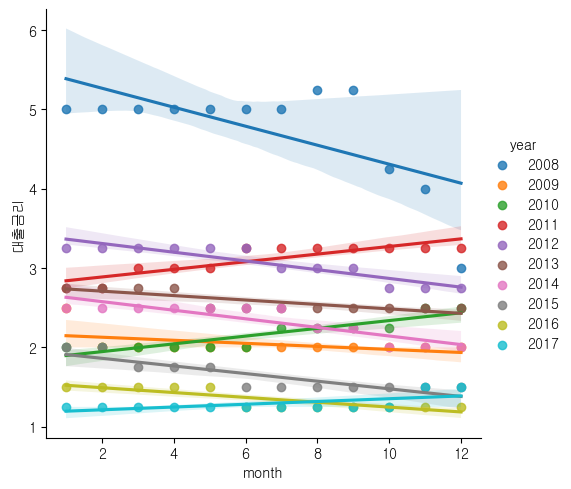

In [32]:
interest['year'] = interest['transaction_year_month'].dt.year
interest['month'] = interest['transaction_year_month'].dt.month
sns.lmplot(x= 'month', y = '대출금리', hue = 'year',data = interest)

 <span style="background-color:#FFE6E6"> **외부데이터 04-1. "서울 평균 소득"**

In [33]:
import chardet

with open('서울시 소득소비-행정동.csv', 'rb') as file:
    rawdata = file.read()
    result = chardet.detect(rawdata)
    encoding = result['encoding']

seoul_money = pd.read_csv('서울시 소득소비-행정동.csv', encoding=encoding)

In [34]:
#서울 동 별 소득 데이터 프레임 불러오기
seoul_money = seoul_money[['월_평균_소득_금액', '행정동_코드_명', '기준_년분기_코드']]
seoul_money = seoul_money[seoul_money['기준_년분기_코드'].astype(str).str[:4] == '2021']
seoul_money = seoul_money.rename(columns={'행정동_코드_명': 'dong'})
# 동 별 평균 소득 금액 컬럼 생성
seoul_money = seoul_money.groupby('dong')['월_평균_소득_금액'].sum().reset_index()
seoul_money['월_평균_소득_금액'] = seoul_money['월_평균_소득_금액']/4
total_income = seoul_money['월_평균_소득_금액'].sum()

seoul_money = seoul_money.rename(columns={'월_평균_소득_금액': '평균소득'})

In [35]:
seoul_money['dong'] = seoul_money['dong'].apply(lambda x: re.search(r'(\D+동?)', x).group() if re.search(r'(\D+동?)', x) else x)
seoul_money['dong'] = seoul_money['dong'].apply(lambda x: x + '동' if not re.search(r'동$', x) else x)

# 'dong' 값이 같은 것끼리 묶은 후 평균소득 값을 더하고 개수로 나누기
grouped_dongs = seoul_money.groupby('dong')['평균소득'].agg(['sum', 'count']).reset_index()
grouped_dongs['결과'] = grouped_dongs['sum'] / grouped_dongs['count']

# '결과' 값을 'seoul_money'의 '평균소득' 열로 지정
seoul_money['평균소득'] = seoul_money['dong'].map(grouped_dongs.set_index('dong')['결과'])

seoul_money.drop_duplicates(subset='dong', keep='first', inplace=True)

 <span style="background-color:#FFE6E6"> **외부데이터 04-2. "부산 평균 소득"**

In [36]:
# 서울에서 했던 처리와 동일
busan_money = pd.read_csv('busan_money.csv')
busan_money = busan_money.rename(columns={'SIGNGU_NM': 'gu'})
busan_money = busan_money[busan_money['BASE_YEAR'] == 2021]
busan_money['AVRG_FYER_INCOME_PRICE'] = busan_money['AVRG_FYER_INCOME_PRICE']*100
busan_money = busan_money.groupby('gu')['AVRG_FYER_INCOME_PRICE'].sum().reset_index()
busan_money['AVRG_FYER_INCOME_PRICE'] = busan_money['AVRG_FYER_INCOME_PRICE']/4
busan_money = busan_money.rename(columns={'AVRG_FYER_INCOME_PRICE': '평균소득'})

In [37]:
income_level = busan_money.groupby('gu')['평균소득'].sum() / 4

busan_money['소득수준'] = busan_money['gu'].map(income_level)
total_income = busan_money['평균소득'].sum()

busan_money['소득비율'] = (busan_money['평균소득'] / total_income) * 100
count = df[df['city'] == '부산광역시'].groupby('gu')['dong'].unique().apply(len).reset_index()

In [38]:
# 'city' 값이 '서울특별시'인 경우 'df'에 'dong'을 기준으로 'seoul_money'의 '평균소득' 컬럼 합하기
seoul_condition = df['city'] == '서울특별시'
seoul_dong_income = df.loc[seoul_condition, 'dong'].map(seoul_money.groupby('dong')['평균소득'].sum())
df.loc[seoul_condition, '평균소득'] = seoul_dong_income

# 'city' 값이 '부산광역시'인 경우 'df'에 'gu'를 기준으로 'busan_money'의 '평균소득' 컬럼 합하기
busan_condition = df['city'] == '부산광역시'
busan_gu_income = df.loc[busan_condition, 'gu'].map(busan_money.groupby('gu')['평균소득'].sum())
df.loc[busan_condition, '평균소득'] = busan_gu_income

# 결측치 처리
for i in df[df['평균소득'].isna()]['gu'].unique():
    df.loc[df['gu'] == i,'평균소득'] = df[df['gu'] == i]['평균소득'].mean()

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851587 entries, 0 to 851586
Data columns (total 34 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          851587 non-null  int64         
 1   apartment_id            851587 non-null  int64         
 2   city                    851587 non-null  object        
 3   dong                    851587 non-null  object        
 4   jibun                   851587 non-null  object        
 5   apt                     851587 non-null  object        
 6   addr_kr                 851587 non-null  object        
 7   exclusive_use_area      851587 non-null  float64       
 8   year_of_completion      851587 non-null  int64         
 9   transaction_year_month  851587 non-null  datetime64[ns]
 10  transaction_date        851587 non-null  object        
 11  floor                   851587 non-null  int64         
 12  transaction_real_price  851587

In [40]:
# 'city' 값이 '서울특별시'인 경우 'df'에 'dong'을 기준으로 'seoul_money'의 '평균소득' 컬럼 합하기
seoul_condition = test['city'] == '서울특별시'
seoul_dong_income = test.loc[seoul_condition, 'dong'].map(seoul_money.groupby('dong')['평균소득'].sum())
test.loc[seoul_condition, '평균소득'] = seoul_dong_income

# 'city' 값이 '부산광역시'인 경우 'df'에 'gu'를 기준으로 'busan_money'의 '평균소득' 컬럼 합하기
busan_condition = test['city'] == '부산광역시'
busan_gu_income = test.loc[busan_condition, 'gu'].map(busan_money.groupby('gu')['평균소득'].sum())
test.loc[busan_condition, '평균소득'] = busan_gu_income

# 결측치 처리
for i in test[test['평균소득'].isna()]['gu'].unique():
    test.loc[test['gu'] == i,'평균소득'] = test[test['gu'] == i]['평균소득'].mean()

> ### test 데이터 확인
- apartment_id / 아파트 아이디
- city / 도시
- dong / 동
- jibun / 지번
- apt / 아파트단지 이름
- addr_kr / 주소
- exclusive_use_area / 전용면적
- year_of_completion / 설립일자
- transaction_year_month / 거래년월
- transaction_date / 거래날짜
- floor / 층
- transaction_real_price / 실거래가

<Axes: >

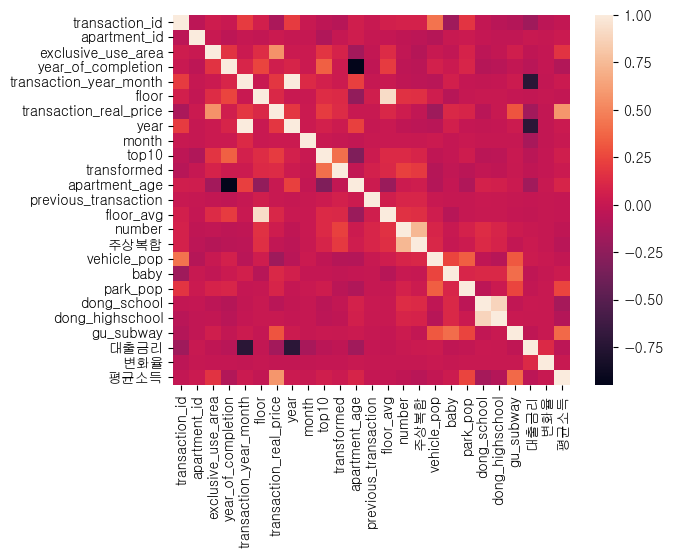

In [41]:
df_numeric = df.select_dtypes(exclude = 'object')
df_object = df.select_dtypes(include = 'object')
sns.heatmap(df_numeric.corr())

In [42]:
def feat(df):
    df['최강'] = df['평균소득'] * df['gu_subway'] * df['exclusive_use_area']
    df['최강'] = np.sqrt(df['최강'])
    df['부자'] = df['최강'] * df['top10'] * df['주상복합']
    df['subsubway'] = df['gu_subway'] ** 2
    df['exclusive_use_area2'] = df['exclusive_use_area'] ** 2
    df['대출금리2'] = df['대출금리'] **2
    df['층과_면적'] = df['floor'] * df['exclusive_use_area']
    df['학교_수'] = df['dong_highschool'] * df['dong_school']
    df['역학세권'] = df['학교_수'] * df['gu_subway']
    df['아파트'] = df['previous_transaction'] * df['apartment_age']
    df['운전학교'] = df['학교_수'] * df['vehicle_pop']
    df['종합'] = df['transformed'] * df['층과_면적'] * df['baby']
    df['상가'] = df['주상복합'] * df['floor_avg'] * df['exclusive_use_area']
    df['몰라'] =  df['number'] * df['gu_subway']
    df['돈'] = df['평균소득'] * df['층과_면적']
    df['층'] = df['floor_avg'] * df['대출금리'] * df['최강']
    df['주변'] = df['상가'] * df['역학세권']
    df['minus'] = df['vehicle_pop'] * df['대출금리']
    return df

df = feat(df)
test = feat(test)

In [43]:
df['transaction_real_price']

0         23500
1         17000
2          7500
3         62500
4         24600
          ...  
851582    40000
851583    40500
851584    31600
851585    23250
851586    15600
Name: transaction_real_price, Length: 851587, dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851587 entries, 0 to 851586
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          851587 non-null  int64         
 1   apartment_id            851587 non-null  int64         
 2   city                    851587 non-null  object        
 3   dong                    851587 non-null  object        
 4   jibun                   851587 non-null  object        
 5   apt                     851587 non-null  object        
 6   addr_kr                 851587 non-null  object        
 7   exclusive_use_area      851587 non-null  float64       
 8   year_of_completion      851587 non-null  int64         
 9   transaction_year_month  851587 non-null  datetime64[ns]
 10  transaction_date        851587 non-null  object        
 11  floor                   851587 non-null  int64         
 12  transaction_real_price  851587

# **02. Outlier & Encoding & Scaling**

### **이상치 처리**

In [45]:
# df_numeric = df.select_dtypes(exclude= 'object')

In [46]:
# # target 값과 가장 관련이 높은 수치형 컬럼들 찾아내기
# print("Find most important features relative to target")
# corr = df_numeric.corr()
# corr.sort_values(["transaction_real_price"], ascending = False, inplace = True)
# print(corr.transaction_real_price)

In [47]:
# df_numeric.drop(columns = 'transaction_year_month', inplace=True)

### **Scaling**

In [48]:
'''target = df['transaction_real_price']
features = df
features.drop(columns = 'transaction_real_price', inplace=True)
sns.distplot(target)'''

"target = df['transaction_real_price']\nfeatures = df\nfeatures.drop(columns = 'transaction_real_price', inplace=True)\nsns.distplot(target)"

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851587 entries, 0 to 851586
Data columns (total 51 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          851587 non-null  int64         
 1   apartment_id            851587 non-null  int64         
 2   city                    851587 non-null  object        
 3   dong                    851587 non-null  object        
 4   jibun                   851587 non-null  object        
 5   apt                     851587 non-null  object        
 6   addr_kr                 851587 non-null  object        
 7   exclusive_use_area      851587 non-null  float64       
 8   year_of_completion      851587 non-null  int64         
 9   transaction_year_month  851587 non-null  datetime64[ns]
 10  transaction_date        851587 non-null  object        
 11  floor                   851587 non-null  int64         
 12  transaction_real_price  851587

후에 모델링에서 pipeline에서 MinMaxScaler 적용

### **Encoding**

- 값이 얼마 없는 city, transaction_date 는 원핫인코딩
- 만 개가 넘는 값들을 가진 dong, apt, gu는 이진인코딩 사용

In [50]:
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder
import category_encoders as ce

In [51]:
# city 컬럼
ohe = OneHotEncoder()
df_onehot = ohe.fit_transform(df[['city']]).toarray()
df_onehot = pd.DataFrame(df_onehot, columns = ohe.get_feature_names_out(['city']))
df = pd.concat([df, df_onehot], axis = 1)
test_onehot = ohe.transform(test[['city']]).toarray()
test_onehot = pd.DataFrame(test_onehot, columns = ohe.get_feature_names_out(['city']))
test = pd.concat([test,test_onehot], axis = 1)

In [52]:
df['transaction_real_price']

0         23500
1         17000
2          7500
3         62500
4         24600
          ...  
851582    40000
851583    40500
851584    31600
851585    23250
851586    15600
Name: transaction_real_price, Length: 851587, dtype: int64

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851587 entries, 0 to 851586
Data columns (total 53 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   transaction_id          851587 non-null  int64         
 1   apartment_id            851587 non-null  int64         
 2   city                    851587 non-null  object        
 3   dong                    851587 non-null  object        
 4   jibun                   851587 non-null  object        
 5   apt                     851587 non-null  object        
 6   addr_kr                 851587 non-null  object        
 7   exclusive_use_area      851587 non-null  float64       
 8   year_of_completion      851587 non-null  int64         
 9   transaction_year_month  851587 non-null  datetime64[ns]
 10  transaction_date        851587 non-null  object        
 11  floor                   851587 non-null  int64         
 12  transaction_real_price  851587

In [54]:
# season 컬럼
ohe = OneHotEncoder()
df_onehot = ohe.fit_transform(df[['season']]).toarray()
df_onehot = pd.DataFrame(df_onehot, columns = ohe.get_feature_names_out(['season']))
df = pd.concat([df, df_onehot], axis = 1)
test_onehot = ohe.transform(test[['season']]).toarray()
test_onehot = pd.DataFrame(test_onehot, columns = ohe.get_feature_names_out(['season']))
test = pd.concat([test,test_onehot], axis = 1)

# transaction_date 컬럼
ohe = OneHotEncoder()
df_onehot = ohe.fit_transform(df[['transaction_date']]).toarray()
df_onehot = pd.DataFrame(df_onehot, columns = ohe.get_feature_names_out(['transaction_date']))
df = pd.concat([df, df_onehot], axis = 1)
test_onehot = ohe.transform(test[['transaction_date']]).toarray()
test_onehot = pd.DataFrame(test_onehot, columns = ohe.get_feature_names_out(['transaction_date']))
test = pd.concat([test,test_onehot], axis = 1)

# dong 컬럼
ce_encoder1 = BinaryEncoder(cols = 'dong')
newdata = ce_encoder1.fit_transform(df['dong'])
df = pd.concat([df,newdata], axis = 1)
test_encoder1 = ce_encoder1.transform(test['dong'])
test =pd.concat([test,test_encoder1], axis = 1)

# apt 컬럼
encoder = ce.TargetEncoder(cols=['apt'])
df['apt'] = encoder.fit_transform(df['apt'], df['transaction_real_price'])
test['apt'] = encoder.transform(test['apt'])

# apartment 컬럼
ce_encoder = BinaryEncoder(cols = 'apartment')
newdata = ce_encoder.fit_transform(df['apartment'])
df = pd.concat([df,newdata], axis = 1)
test_encoder1 = ce_encoder.transform(test['apartment'])
test =pd.concat([test,test_encoder1], axis = 1)

# gu 컬럼
ce_encoder1 = BinaryEncoder(cols = 'gu')
newdata = ce_encoder1.fit_transform(df['gu'])
df = pd.concat([df,newdata], axis = 1)
test_encoder1 = ce_encoder1.transform(test['gu'])
test =pd.concat([test,test_encoder1], axis = 1)

# ----
df.drop(columns = ['apartment_id','apartment','transaction_id','addr_kr','transaction_year_month','city','dong','jibun','transaction_date','gu','season'],inplace=True)
test.drop(columns = ['apartment_id','apartment','transaction_id','addr_kr','transaction_year_month','city','dong','jibun','transaction_date','gu','season'],inplace=True)

# **03. Modeling**

In [55]:
# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.base import ClassifierMixin

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss

In [56]:
target = df['transaction_real_price']
features = df
features.drop(columns = 'transaction_real_price', inplace=True)

In [57]:
print(features.shape, test.shape)

(851587, 80) (364966, 80)


<Axes: xlabel='transaction_real_price', ylabel='Density'>

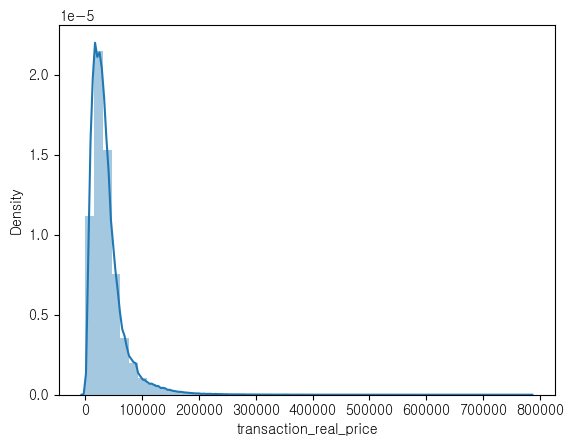

In [58]:
sns.distplot(target)

### **Feature Importance 확인**

In [59]:
from lightgbm import LGBMClassifier
import lightgbm as lgb

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.073289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4354
[LightGBM] [Info] Number of data points in the train set: 851587, number of used features: 80
[LightGBM] [Info] Start training from score 38239.118695


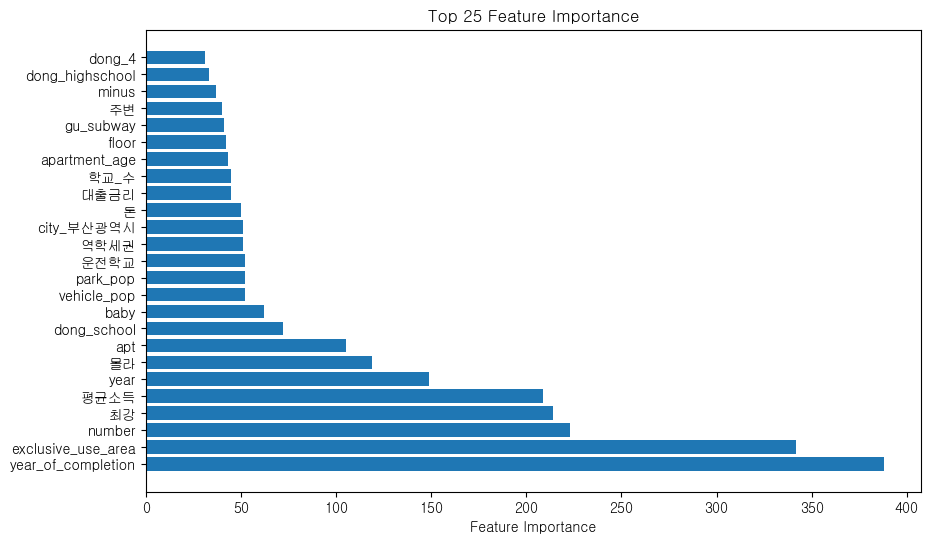

In [60]:
# LightGBM 모델 초기화
model = lgb.LGBMRegressor()

# 모델을 학습시키기 전에 원본 데이터로 복사하여 중요도 계산
model.fit(features, target)

# 피쳐 중요도 가져오기
feature_importance = model.feature_importances_

# 중요도가 높은 상위 25개 피쳐 인덱스 가져오기
top_25_feature_indices = feature_importance.argsort()[-25:][::-1]

# 상위 25개 피쳐의 중요도 가져오기
top_25_feature_importance = feature_importance[top_25_feature_indices]

# 상위 20개 피쳐의 이름 가져오기
top_25_feature_names = features.columns[top_25_feature_indices]

# 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(top_25_feature_names, top_25_feature_importance)
plt.xlabel('Feature Importance')
plt.title('Top 25 Feature Importance')
plt.show()

- shap 중요도 확인

In [61]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [62]:
from xgboost import XGBRegressor, plot_importance
import shap

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.068774 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4349
[LightGBM] [Info] Number of data points in the train set: 681269, number of used features: 80
[LightGBM] [Info] Start training from score 38243.963084


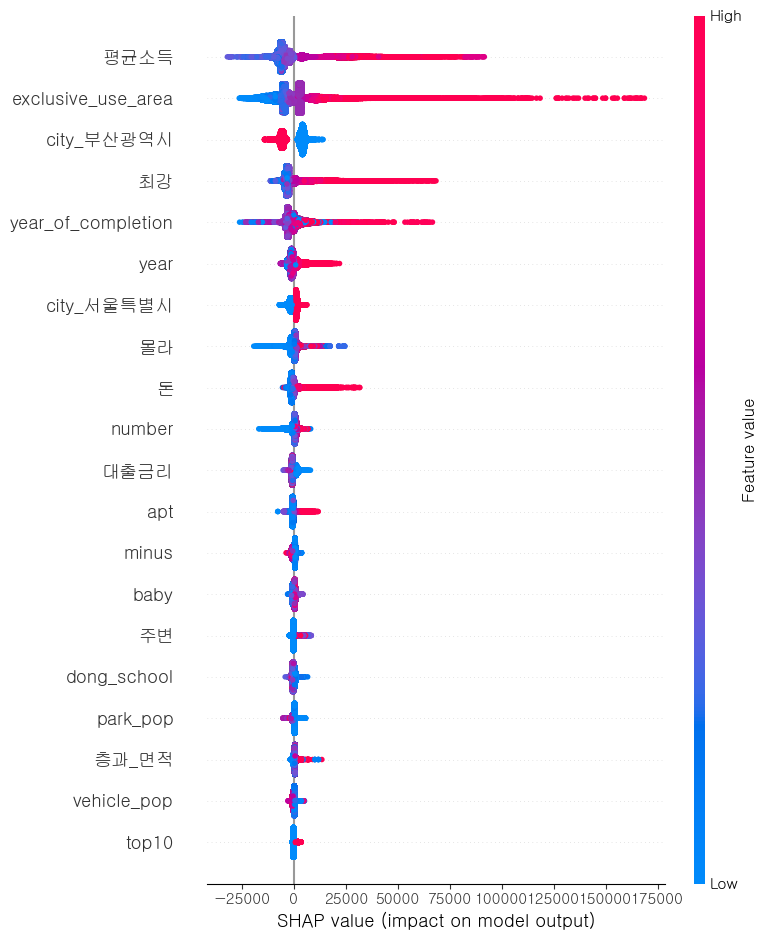

In [63]:
model = lgb.LGBMRegressor()
model.fit(X_train,y_train)
plt.figure(figsize=(10, 6))
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

- 실제 모델에 적용

In [64]:
def rmse_score(y,y_pred):
    a = 0
    for i,j in zip(y,y_pred):
        a += (i-j)**2
    return np.sqrt(a/len(y))
from sklearn.model_selection import  KFold
from tqdm import tqdm
import lightgbm as lgb
lgbm = lgb.LGBMRegressor()
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ensemble_predictions = []
scores = []
for train_idx, val_idx in tqdm(kf.split(features), total = 5, desc = "processing folds"):
    X_t, X_val = features.iloc[train_idx], features.iloc[val_idx]
    y_t, y_val = target.iloc[train_idx], target.iloc[val_idx]
    lgbm.fit(X_t,y_t)
    val_pred = lgbm.predict(X_val)
    #val_pred = np.exp(val_pred)
    #y_val = np.exp(y_val)
    scores.append(rmse_score(y_val, val_pred))

    lgbm_pred = lgbm.predict(test)
    #lgbm_pred = np.exp(lgbm_pred)
    lgbm_pred = np.where(lgbm_pred<0, 0, lgbm_pred)
    ensemble_predictions.append(lgbm_pred)
final_predictions = np.mean(ensemble_predictions,axis = 0)
print("Validation : RMSE scores for each fold:", scores)
print("Validation : RMSE", np.mean(scores))

processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.072043 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 681269, number of used features: 80
[LightGBM] [Info] Start training from score 38243.963084


processing folds:  20%|██        | 1/5 [00:12<00:50, 12.70s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092097 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4357
[LightGBM] [Info] Number of data points in the train set: 681269, number of used features: 80
[LightGBM] [Info] Start training from score 38227.304012


processing folds:  40%|████      | 2/5 [00:23<00:35, 11.69s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4347
[LightGBM] [Info] Number of data points in the train set: 681270, number of used features: 80
[LightGBM] [Info] Start training from score 38256.179481


processing folds:  60%|██████    | 3/5 [00:32<00:21, 10.58s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.084003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4351
[LightGBM] [Info] Number of data points in the train set: 681270, number of used features: 80
[LightGBM] [Info] Start training from score 38226.005936


processing folds:  80%|████████  | 4/5 [00:42<00:10, 10.15s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.091051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4350
[LightGBM] [Info] Number of data points in the train set: 681270, number of used features: 80
[LightGBM] [Info] Start training from score 38242.140951


processing folds: 100%|██████████| 5/5 [00:53<00:00, 10.77s/it]

Validation : RMSE scores for each fold: [7003.4627952687815, 6907.14179038844, 6869.260690646191, 6936.100390989003, 6990.3920614181025]
Validation : RMSE 6941.271545742103


# ---- <span style="color:red"> **최종** </span> ---------------------------------
## **Hist Gradient Boosting Regressor 모델 적용**
- 하이퍼 파라미터 튜닝

In [65]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.compose import ColumnTransformer
import optuna
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler

In [67]:
%%time
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', MinMaxScaler(), features.columns),
    ], remainder='passthrough'
)

#Best Parameters using OPTUNA
params = {'max_iter': 1669, 'max_leaf_nodes': 167, 'max_depth': 13,
         'min_samples_leaf': 38, 'l2_regularization': 0.06837989932119798}

pipe = Pipeline(
    [
        ('MIN',preprocessor),
        ('HIST',HistGradientBoostingRegressor(random_state=42, loss='squared_error', **params))
    ]
)

pipe.fit(features,target)

CPU times: total: 24min 3s
Wall time: 5min 51s


Pipeline(steps=[('MIN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', MinMaxScaler(),
                                                  Index(['apt', 'exclusive_use_area', 'year_of_completion', 'floor', 'year',
       'month', 'top10', 'transformed', 'apartment_age',
       'previous_transaction', 'floor_avg', 'number', '주상복합', 'vehicle_pop',
       'baby', 'park_pop', 'dong_school', 'dong_highschool', 'gu_subway',
       '대출금리',...
       'apartment_4', 'apartment_5', 'apartment_6', 'apartment_7',
       'apartment_8', 'apartment_9', 'apartment_10', 'apartment_11',
       'apartment_12', 'apartment_13', 'gu_0', 'gu_1', 'gu_2', 'gu_3', 'gu_4',
       'gu_5'],
      dtype='object'))])),
                ('HIST',
                 HistGradientBoostingRegressor(l2_regularization=0.06837989932119798,
                                               max_depth=13, max_iter=1669,
                                               max_leaf_nodes=167,
                                               min_samples_leaf=38,
                                               random_state=42))])

In [68]:
def objective(trial, data=features, target=target):
  X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=.2, random_state=42)
  param = {
      'max_iter':trial.suggest_int('max_iter', 1500, 2500),
      'max_leaf_nodes':trial.suggest_int('max_leaf_nodes',80, 200),
      'max_depth':trial.suggest_int('max_depth', 10, 15),
      'min_samples_leaf':trial.suggest_int('min_samples_leaf',30,40),
      'l2_regularization':trial.suggest_float('l2_regularization',0.05, 0.1)
  }

  model = HistGradientBoostingRegressor(random_state=42, loss='squared_error', **param)

  model.fit(X_train, y_train)

  preds = model.predict(X_test)

  rmse = rmse_score(y_test, preds)

  return rmse

study = optuna.create_study(direction='minimize')

[I 2023-11-28 13:59:38,291] A new study created in memory with name: no-name-2f0c686c-a53c-42c2-b606-6f34dd2f3877


In [69]:
%%time
fold = KFold(n_splits=5, shuffle=True, random_state=42)
score = cross_val_score(estimator=pipe, X=features, y=target, cv=fold, scoring='neg_mean_absolute_error')
print(np.round(-score,2))
print()
print(f"5 K-FOLD : {np.round(np.mean(-score),2)} & std +/-{np.round(np.std(-score),2)}")

[1853.38 1883.93 1916.31 1844.52 1835.98]

5 K-FOLD : 1866.82 & std +/-29.57
CPU times: total: 1h 43min 16s
Wall time: 24min 44s


In [70]:
# n_trials : 튜닝 횟수
study.optimize(objective, n_trials=5)

[I 2023-11-28 14:29:02,658] Trial 0 finished with value: 3917.6690143303144 and parameters: {'max_iter': 2183, 'max_leaf_nodes': 200, 'max_depth': 11, 'min_samples_leaf': 39, 'l2_regularization': 0.06057361823222268}. Best is trial 0 with value: 3917.6690143303144.
[I 2023-11-28 14:34:04,835] Trial 1 finished with value: 3909.8144693462973 and parameters: {'max_iter': 2400, 'max_leaf_nodes': 197, 'max_depth': 13, 'min_samples_leaf': 37, 'l2_regularization': 0.057418783171985024}. Best is trial 1 with value: 3909.8144693462973.
[I 2023-11-28 14:37:51,788] Trial 2 finished with value: 3996.3498700026244 and parameters: {'max_iter': 1913, 'max_leaf_nodes': 154, 'max_depth': 11, 'min_samples_leaf': 35, 'l2_regularization': 0.06126016387722152}. Best is trial 1 with value: 3909.8144693462973.
[I 2023-11-28 14:44:01,440] Trial 3 finished with value: 3911.032254549325 and parameters: {'max_iter': 1798, 'max_leaf_nodes': 128, 'max_depth': 12, 'min_samples_leaf': 31, 'l2_regularization': 0.0507

In [71]:
study.best_params

{'max_iter': 1707,
 'max_leaf_nodes': 186,
 'max_depth': 10,
 'min_samples_leaf': 31,
 'l2_regularization': 0.06501170497618809}

- 튜닝을 통해 찾은 best parameter를 적용

In [74]:
%%time
preprocessor = ColumnTransformer(
    transformers=[
        ('ss', MinMaxScaler(), features.columns),
    ], remainder='passthrough'
)

#Best Parameters using OPTUNA
params = {'max_iter': 2414, 'max_leaf_nodes': 175, 'max_depth': 10,
            'min_samples_leaf': 36, 'l2_regularization': 0.05704545550641109}

pipe = Pipeline(
    [
        ('MIN',preprocessor),
        ('HIST',HistGradientBoostingRegressor(random_state=42, loss='squared_error', **params))
    ]
)

pipe.fit(features,target)

CPU times: total: 27min 19s
Wall time: 7min 8s


Pipeline(steps=[('MIN',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ss', MinMaxScaler(),
                                                  Index(['apt', 'exclusive_use_area', 'year_of_completion', 'floor', 'year',
       'month', 'top10', 'transformed', 'apartment_age',
       'previous_transaction', 'floor_avg', 'number', '주상복합', 'vehicle_pop',
       'baby', 'park_pop', 'dong_school', 'dong_highschool', 'gu_subway',
       '대출금리',...
       'apartment_4', 'apartment_5', 'apartment_6', 'apartment_7',
       'apartment_8', 'apartment_9', 'apartment_10', 'apartment_11',
       'apartment_12', 'apartment_13', 'gu_0', 'gu_1', 'gu_2', 'gu_3', 'gu_4',
       'gu_5'],
      dtype='object'))])),
                ('HIST',
                 HistGradientBoostingRegressor(l2_regularization=0.05704545550641109,
                                               max_depth=10, max_iter=2414,
                                               max_leaf_nodes=175,
                                               min_samples_leaf=36,
                                               random_state=42))])

In [75]:
# 실제 모델 예측하고 제출할 csv파일에 컬럼 추가
prediction = pipe.predict(test).clip(0,)
sample_submission = pd.read_csv('./submission.csv')
sample_submission['transaction_real_price'] = prediction
sample_submission

,transaction_id,transaction_real_price
0,1500000,78959.399321
1,1500001,40353.556175
2,1500002,37779.509656
3,1500003,26316.283758
4,1500004,20973.984401
...,...,...
364961,1864961,22565.238664
364962,1864962,22899.789391
364963,1864963,28520.275517
364964,1864964,28766.464117


<Axes: >

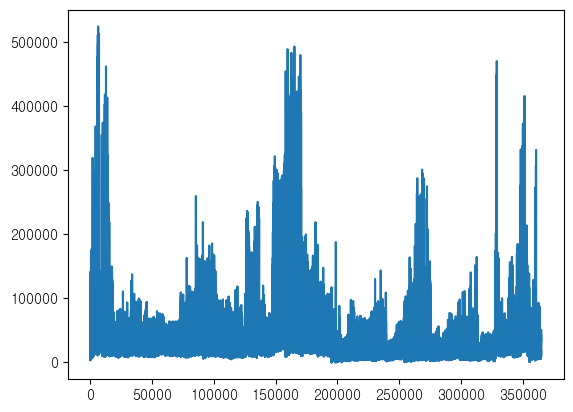

In [76]:
sample_submission['transaction_real_price'].plot()

In [77]:
sample_submission.to_csv('./sub11260100.csv', index=False) #새로 csv파일 저장

# **Submission 저장**

In [78]:
submission = pd.read_csv('./submission.csv')
submission['transaction_real_price'] = final_predictions #새로 transaction real price행을 추가하고
submission

,transaction_id,transaction_real_price
0,1500000,102036.378783
1,1500001,45966.739623
2,1500002,42856.456720
3,1500003,31989.978086
4,1500004,23365.690002
...,...,...
364961,1864961,24095.064258
364962,1864962,25484.885096
364963,1864963,34432.313713
364964,1864964,32825.346141


# **최종 파일 생성**

In [79]:
submission.to_csv('./최종.csv', index=False) #새로 csv파일 저장